# try to implement  
## "Towards End-to-End Speech Recognition with Deep Convolutional Neural Networks"

In [4]:
!nvidia-smi | head -n 31

Tue Jan 30 17:01:36 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:04:00.0 Off |                    0 |
| N/A   51C    P0    68W / 149W |   7375MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:05:00.0 Off |                    0 |
| N/A   42C    P0    80W / 149W |   6735MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [5]:
SAMPLE_RATE = 16000
WINDOW_SIZE = .02
WINDOW_STRIDE = .01
WINDOW = 'hamming'

HIDDEN_LAYERS = 5
#RNN_TYPE = supported_rnns['gru']
BIDIRECTIONAL = True

BEGINING_LEARNING_RATE = 3e-4
MOMENTUM = 0.9
MAX_NORM = 3
#LABELS = ''.join(data_utils.LABELS)
BATCH_SIZE = 32

GPU_CORES = ['/gpu:2','/gpu:3']
REMOTE_WORKER = "grpc://10.109.246.8:2224"
RNN_SIZE = 400#768
MODEL_NAME = "1_29-pinyin-opt-aug"
#audio_conf = dict(sample_rate=SAMPLE_RATE,
#                  window_size=WINDOW_SIZE,
#                  window_stride=WINDOW_STRIDE,
#                  window=WINDOW,
#                )

In [6]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(i) for i in GPU_CORES])

In [7]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../common/')
import data_utils
import utils
from utils import Dataset,ProgressBar
import tflearn
from tflearn.data_flow import DataFlow,DataFlowStatus,FeedDictFlow
#from model import DeepSpeech,supported_rnns
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
#import sugartensor as tf
import re
import pypinyin
from pypinyin import pinyin, lazy_pinyin, Style
import time
import os

In [8]:
np.zeros([3,2]).size

6

## The implemention of pytorch's DataLoader is not competiable with tflearn's DataFlow
```python
train_loader = data_utils.AudioDataLoader(
    data_utils.SpectrogramDataset(manifest_filepath='./data/ted_train_manifest_fix.csv')
    ,batch_size=16,shuffle=True)

test_loader = data_utils.AudioDataLoader(
    data_utils.SpectrogramDataset(manifest_filepath='./data/ted_test_manifest_fix.csv')
    ,batch_size=16,shuffle=True)
```

In [9]:
import pickle
with open('../data/dics.pkl','rb') as fhdl:
    ch2ind,ind2ch = pickle.load(fhdl)

In [10]:
with open('../data/pinyins.pkl','rb') as whdl:
    py2ind,ind2py = pickle.load(whdl)

In [11]:
import flow_tools

In [12]:
ch2py = lambda x:" ".join([i[0] for i in pinyin(x)])

In [13]:
filesnoise = os.listdir('../data/_background_noise_/')
filesnoise = [i for i in filesnoise if '.wav' in i]

In [14]:
noises = [data_utils.fetch_audio('../data/_background_noise_/{}'.format(i))[1] for i in filesnoise]

/data/zonghua/envs/icybee/lib/python3.5/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [15]:
weights = [1,1,3,1,1,3]

In [16]:
import IPython.display as ipd
audio = data_utils.fetch_audio('../data/data_aishell/wav_uncompress/dev/S0724/BAC009S0724W0121.wav',augmentation_speed=True,augmentation_linear=True,augmentation_speed_rate=0.12)[1]
ipd.Audio(data=audio + 0.02 * noises[5][:len(audio)],rate=16000)

In [17]:
import pandas as pd

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f04def67470>]], dtype=object)

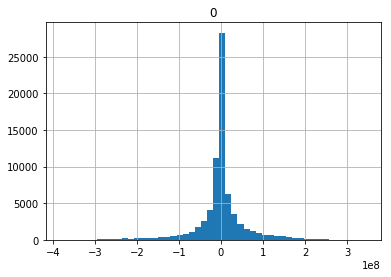

In [18]:
pd.DataFrame(audio).hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f04dbc3b5f8>]], dtype=object)

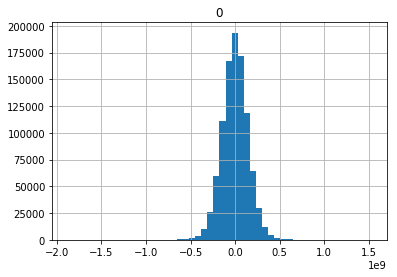

In [19]:
pd.DataFrame(noises[0]).hist(bins=50)

In [20]:
audio

array([ 3801088.        ,  2932362.30836858,    72335.82881314, ...,
        2883584.        ,  2904488.98930175,  3080192.        ])

In [21]:
noises

[array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -4.91520000e+07,  -1.29433600e+08,   1.30416640e+07]),
 array([        0.,         0.,         0., ..., -59375616., -37814272.,
         19595264.]),
 array([  1.41964083e+09,   6.80394752e+08,   9.03741440e+08, ...,
          9.86841088e+08,   5.50633472e+08,   1.17951693e+09]),
 array([        0.,         0.,         0., ..., -12713984.,  -8716288.,
         -5439488.]),
 array([       0.,        0.,        0., ...,  6225920.,  7274496.,
         -720896.]),
 array([ -1.15736576e+08,  -1.05945498e+09,  -1.14537267e+09, ...,
         -5.13998848e+08,   7.87611648e+08,  -3.35020032e+08])]

# CONFIG

In [22]:
#voice_dataset_train = data_utils.VoicesFlow(manifest_filepath='./data/ted_train_manifest_fix.csv')
#voice_flow_train = data_utils.get_flow(voice_dataset_train,shuffle=True,batch_size=BATCH_SIZE)
#
#voice_dataset_test = data_utils.VoicesFlow(manifest_filepath='./data/ted_test_manifest_fix.csv')
#voice_flow_test = data_utils.get_flow(voice_dataset_test,shuffle=False,batch_size=BATCH_SIZE)

voice_dataset_train = data_utils.VoicesFlow(manifest_filepath='../data/csvs/train_len.csv',mfcc=False,phon=False,labels=list(ch2ind.keys()),ch2ind=ch2ind,ind2ch=ind2ch,augmentation_linear=True,augmentation_speed=True,add_noise=True,noises=noises,noise_volumn=0.004,noise_weight=weights)#,phm_dict_file='./data/TEDLIUM_release1/TEDLIUM.150K.dic')
#voice_dataset_train = data_utils.VoicesFlow(manifest_filepath='../data/csvs/train_len.csv',mfcc=False,phon=False,labels=list(ch2ind.keys()),ch2ind=ch2ind,ind2ch=ind2ch)#,phm_dict_file='./data/TEDLIUM_release1/TEDLIUM.150K.dic')
voice_flow_train = utils.SortedEfficientFlowWrapper(voice_dataset_train,batch_size=BATCH_SIZE,shuffle=False)

voice_dataset_test = data_utils.VoicesFlow(manifest_filepath='../data/csvs/dev_len.csv',mfcc=False,phon=False,labels=list(ch2ind.keys()),ch2ind=ch2ind,ind2ch=ind2ch)#,phm_dict_file='./data/TEDLIUM_release1/TEDLIUM.150K.dic')
voice_flow_test = utils.SortedEfficientFlowWrapper(voice_dataset_test,batch_size=BATCH_SIZE,shuffle=False)

In [23]:
voice_flow_train_shu = utils.SortedEfficientFlowWrapper(voice_dataset_train,batch_size=BATCH_SIZE,shuffle=True)
voice_flow_test_shu = utils.SortedEfficientFlowWrapper(voice_dataset_test,batch_size=BATCH_SIZE,shuffle=True)

shuffle
shuffle


In [24]:
import sys

In [25]:
len(voice_dataset_train),len(voice_dataset_test)

(119338, 14326)

In [26]:
from utils import Dataset

In [27]:
start = time.time()
a,b,c,d,e = voice_flow_train.next_batch(BATCH_SIZE)
time.time() - start

0.13453054428100586

In [28]:
chstr = ''.join([ind2ch[i] for i in b[0]])

In [29]:
chstr,pinyin(chstr)

('娱乐频道', [['yú'], ['lè'], ['pín'], ['dào']])

In [30]:
a.shape

(32, 161, 170, 1)

娱乐频道
../data/data_aishell/wav_uncompress/train/S0141/BAC009S0141W0423.wav
../data/transcript/BAC009S0141W0423.txt
112


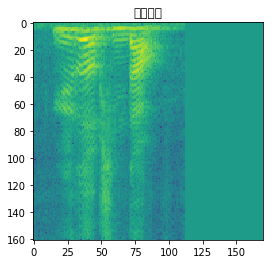

In [31]:
index = 0
#plt.figure(figsize=(30,50))
plt.imshow(a[index,:,:,0])
plt.title(''.join(ind2ch[i] for i in b[index]))
print(''.join(ind2ch[i] for i in b[index]))
print(c[index])
print(d[index])
print(e[index])

In [32]:
import IPython.display as ipd

In [33]:
print(open(d[index],encoding='utf-8').read())
ipd.Audio(c[index])

娱乐频道


In [34]:
def chind2pyind(inputs):
    out = []
    for one in inputs:
        sent = ''.join([ind2ch[i] for i in one])
        outone = ch2py(sent)
        oneoutind = [py2ind.get(i,0) for i in outone]
        out.append(oneoutind)
    return out

In [35]:
''.join([ind2py[i] for i in chind2pyind(b)[0]])

'yú lè pín dào'

# convert data to numpy format

In [36]:
#转化一个序列列表为稀疏矩阵    
def sparse_tuple_from(sequences, dtype=np.int32):
    """
    Create a sparse representention of x.
    Args:
        sequences: a list of lists of type dtype where each element is a sequence
    Returns:
        A tuple with (indices, values, shape)
    """
    sequences = chind2pyind(sequences)
    indices = []
    values = []
    
    for n, seq in enumerate(sequences):
        indices.extend(zip([n] * len(seq), range(len(seq))))
        values.extend(seq)
 
    indices = np.asarray(indices, dtype=np.int64)
    values = np.asarray(values, dtype=dtype)
    shape = np.asarray([len(sequences), np.asarray(indices).max(0)[1] + 1], dtype=np.int64)
    
    
    return indices, values, shape

In [37]:
tf.__version__

'1.2.1'

In [38]:
def conv_layer(input_tensor,training,kernel_size=(3,3),filters=32,dropout=None
               ,clip_net=20.,batch_normalization=True,strides=(1,1,1,1),name="conv_layer"):
    with tf.variable_scope(name):
        net = tf.layers.conv2d(input_tensor,filters=filters,kernel_size=kernel_size,padding='same',strides=strides)
        if batch_normalization:
            net = tf.layers.batch_normalization(net,training=training)
        if dropout is not None:
            net = tf.layers.dropout(net,dropout=1.-dropout)
        net = tf.nn.relu(net)
    with tf.variable_scope("minimal"):
        if clip_net is not None and clip_net != False and clip_net > 0:
            net = tf.minimum(net,tf.Variable(clip_net))
    return net

def rnn_layer(input_tensor,layer_num,rnn_seq_lens,rnn_size,training,name="rnn_layer"):
    """
        input should be like [batch_size,time,freq * filters]
    """
    with tf.variable_scope(name):
        net = input_tensor
        for i in range(layer_num):
            with tf.variable_scope("{}_layer{}".format(name,i + 1)):
                forward_cell = tf.contrib.rnn.GRUCell(rnn_size)
                backward_cell = tf.contrib.rnn.GRUCell(rnn_size)
            #bi_outputs, bi_encoder_state,_ = tf.contrib.rnn.static_bidirectional_rnn(
            #        forward_cell,backward_cell,tf.unstack(net,net_shape[1],1),dtype=tf.float32)

                bi_outputs, bi_encoder_state = tf.nn.bidirectional_dynamic_rnn(
                            forward_cell, backward_cell, net,
                            sequence_length = rnn_seq_lens,time_major = False,dtype=tf.float32)
                outputs_fw, outputs_bw = bi_outputs
                rnn_outputs = outputs_fw + outputs_bw
                rnn_outputs = tf.layers.batch_normalization(rnn_outputs, training=training)
                net = rnn_outputs
        return net
    

def _activation_summary(act,tensor_name):
    """Helper to create summaries for activations.
    Creates a summary that provides a histogram of activations.
    Creates a summary that measure the sparsity of activations.
    Args:
      act: Tensor
    """
    # Remove 'tower_[0-9]/' from the name in case this is a multi-GPU training
    # session. This helps the clarity of presentation on tensorboard.
    tf.summary.histogram(tensor_name + '/activations', act)
    tf.summary.scalar(tensor_name + '/sparsity', tf.nn.zero_fraction(act))
    
def _image_summary(img,tensor_name):
    tf.summary.image(tensor_name,img)

In [39]:
list(range(2,3))

[2]

In [40]:
GPU_CORES

['/gpu:2', '/gpu:3']

In [41]:
def average_gradients(tower_grads):
    """Calculate the average gradient for each shared variable across all towers.
    Note that this function provides a synchronization point across all towers.
    Args:
    tower_grads: List of lists of (gradient, variable) tuples. The outer list
      is over individual gradients. The inner list is over the gradient
      calculation for each tower.
    Returns:
     List of pairs of (gradient, variable) where the gradient has been averaged
     across all towers.


    """
    average_grads = []
    for grad_and_vars in zip(*tower_grads):
        # Note that each grad_and_vars looks like the following:
        #   ((grad0_gpu0, var0_gpu0), ... , (grad0_gpuN, var0_gpuN))
        grads = []
        for g, _ in grad_and_vars:
            # Add 0 dimension to the gradients to represent the tower.
            expanded_g = tf.expand_dims(g, 0)
            # Append on a 'tower' dimension which we will average over below.
            grads.append(expanded_g)

        # Average over the 'tower' dimension.
        grad = tf.concat(grads,0)
        grad = tf.reduce_mean(grad, 0)

        # Keep in mind that the Variables are redundant because they are shared
        # across towers. So .. we will just return the first tower's pointer to
        # the Variable.
        v = grad_and_vars[0][1]
        grad_and_var = (grad, v)
        average_grads.append(grad_and_var)
    return average_grads

In [42]:
list(enumerate(GPU_CORES))

[(0, '/gpu:2'), (1, '/gpu:3')]

In [43]:
assert(len(GPU_CORES) <= 4)
gpu_num = len(GPU_CORES)
tf.reset_default_graph()

graph = tf.Graph()
with graph.as_default():
    initializer = tf.truncated_normal_initializer(
        mean=0.0,stddev=0.02)
    tf.get_variable_scope().set_initializer(initializer)
    
    if gpu_num >= 1:
        input_sound1 = tf.placeholder(tf.float32,shape=[BATCH_SIZE,161,None,1])
        targets1 = tf.sparse_placeholder(tf.int32)
    if gpu_num >= 2:
        input_sound2 = tf.placeholder(tf.float32,shape=[BATCH_SIZE,161,None,1])
        targets2 = tf.sparse_placeholder(tf.int32)
    if gpu_num >= 3:
        input_sound3 = tf.placeholder(tf.float32,shape=[BATCH_SIZE,161,None,1])
        targets3 = tf.sparse_placeholder(tf.int32)
    if gpu_num >= 4:
        input_sound4 = tf.placeholder(tf.float32,shape=[BATCH_SIZE,161,None,1])
        targets4 = tf.sparse_placeholder(tf.int32)
    # [batch_size,freq,time,1]

    voicelength = tf.placeholder(tf.int32, shape=(BATCH_SIZE * gpu_num))
    global_step = tf.train.get_or_create_global_step()
    max_grad = tf.placeholder(tf.float32)
    
    #, shape=np.array([BATCH_SIZE,4], dtype=np.int64))

    learning_rate = tf.placeholder(tf.float32)
    training=tf.placeholder(tf.bool)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    optimizer_sgd = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9)
    tower_gradients = []
    tower_gradients_sgd = []

with graph.as_default():
    with tf.variable_scope(tf.get_variable_scope()) as vscope:
        for ind,one_core in enumerate(GPU_CORES):
            print(ind)
            with tf.device("".format(one_core)):
                if ind == 0:
                    targets = targets1
                    input_sound = input_sound1
                elif ind == 1:
                    targets = targets2
                    input_sound = input_sound2
                elif ind == 2:
                    targets = targets3
                    input_sound = input_sound3
                elif ind == 3:
                    targets = targets4
                    input_sound = input_sound4

                conv1 = conv_layer(input_sound,training,kernel_size=(41,11),filters=32,strides=(2,2),name="deepspeech_conv_layer1")
                conv2 = conv_layer(conv1,training,kernel_size=(21,11),filters=32,strides=(2,1),name="deepspeech_conv_layer2")
                conv3 = conv_layer(conv2,training,kernel_size=(21,11),filters=96,strides=(2,1),name="deepspeech_conv_layer3")# filters=96 according to paper


                net = conv3
                net = tf.transpose(net,[0,2,1,3])
                net_shape = net.get_shape().as_list()
                net = tf.reshape(net,[BATCH_SIZE,-1,net_shape[-1] * net_shape[-2]])
                # [batch_size,time,freq * filters]
                rnn_out = rnn_layer(net,HIDDEN_LAYERS,voicelength[ind * BATCH_SIZE:(ind + 1) * BATCH_SIZE],RNN_SIZE,training=training,name="deepspeech_rnn_layer")
                _activation_summary(rnn_out,'rnn_output')
                net_result = tf.layers.dense(rnn_out,len(ind2py) + 2,activation=None,name="deepspeech_dense")
                _activation_summary(net_result,'net_result')

                with tf.variable_scope("Loss"):
                    ctc_loss = tf.nn.ctc_loss(labels=targets,inputs=net_result,sequence_length=voicelength[ind * BATCH_SIZE:(ind + 1) * BATCH_SIZE]
                                              ,time_major=False)
                    loss = tf.reduce_mean(ctc_loss)
                    tf.summary.scalar("Loss",loss)

                with tf.variable_scope("LearningRate"):
                    tf.summary.scalar("LearningRate",learning_rate)


                decoded, log_prob = tf.nn.ctc_beam_search_decoder(tf.transpose(net_result, (1, 0, 2)),
                                                                  sequence_length=voicelength[ind * BATCH_SIZE:(ind + 1) * BATCH_SIZE],merge_repeated=False)
                dense_decoded = tf.cast(tf.sparse_tensor_to_dense(decoded[0], default_value=0), tf.int32)

                with tf.variable_scope("EditDistance"):
                    dis = tf.reduce_mean(tf.edit_distance(tf.cast(decoded[0], tf.int32), targets))
                    tf.summary.scalar("EditDistance",dis)

                trainable_params = tf.trainable_variables()
                trainable_params = [i for i in trainable_params if
                                    ('deepspeech' in i.name and 'Minimum_grad' not in i.name)]
                #grads_e = optimizer.compute_gradients(ctc_loss, var_list = trainable_params)
                #grads_e_sgd = optimizer_sgd.compute_gradients(ctc_loss, var_list = trainable_params)
                #gradients = tf.gradients(ctc_loss, trainable_params)
                #clip_gradients, _ = tf.clip_by_global_norm(gradients, max_grad)
                #clip_gradients_sgd, _ = tf.clip_by_global_norm(gradients, max_grad)
                #L_loss = tf.clip_by_value(loss, -max_grad, max_grad)
                L_loss = loss
                tf.get_variable_scope().reuse_variables()
                #train_op = optimizer.minimize(loss,global_step=global_step)
                #train_op = optimizer.apply_gradients(
                #        zip(clip_gradients, trainable_params), global_step=global_step)
                grads_e_ori = optimizer.compute_gradients(L_loss, var_list = trainable_params)
                grads_e_ori = [i[0] for i in grads_e_ori]
                grads_e, _ = tf.clip_by_global_norm(grads_e_ori, max_grad)
                #grads_e = grads_e_ori
                grads_e_sgd_ori = optimizer_sgd.compute_gradients(L_loss, var_list = trainable_params)
                grads_e_sgd_ori = [i[0] for i in grads_e_sgd_ori]
                grads_e_sgd, _ = tf.clip_by_global_norm(grads_e_sgd_ori, max_grad)
                #grads_e_sgd = grads_e_sgd_ori
                tower_gradients.append(zip(grads_e,trainable_params))
                tower_gradients_sgd.append(zip(grads_e_sgd,trainable_params))
                print('finish {}'.format(ind))


with graph.as_default():
    summary_op = tf.summary.merge_all()
    train_summary_writer = tf.summary.FileWriter("./log/compair/{}".format(MODEL_NAME), graph)
        
    grads = average_gradients(tower_gradients)
    grads_sgd = average_gradients(tower_gradients_sgd)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_op = optimizer.apply_gradients(grads,global_step)
        train_op_sgd = optimizer_sgd.apply_gradients(grads_sgd,global_step)
    with tf.variable_scope("Validation"):
        test_loss = tf.placeholder(tf.float32)
        loss_op = tf.summary.scalar("Accuracy",test_loss)
        editdistance = tf.placeholder(tf.float32)
        editdistance_op = tf.summary.scalar("EditDistance",editdistance)
    test_op = tf.summary.merge([loss_op,editdistance_op])


0
finish 0
1
finish 1


In [44]:
grads_e[:2]

[<tf.Tensor 'clip_by_global_norm_2/clip_by_global_norm_2/_0:0' shape=<unknown> dtype=float32>,
 <tf.Tensor 'clip_by_global_norm_2/clip_by_global_norm_2/_1:0' shape=<unknown> dtype=float32>]

In [45]:
grads_e_ori[:2]

[<tf.Tensor 'gradients_2/deepspeech_conv_layer1_1/conv2d/convolution_grad/tuple/control_dependency_1:0' shape=(41, 11, 1, 32) dtype=float32>,
 <tf.Tensor 'gradients_2/deepspeech_conv_layer1_1/conv2d/BiasAdd_grad/tuple/control_dependency_1:0' shape=(32,) dtype=float32>]

In [46]:
net_result.shape,net.shape,ctc_loss.shape,net.shape,net_shape

(TensorShape([Dimension(32), Dimension(None), Dimension(56)]),
 TensorShape([Dimension(32), Dimension(None), Dimension(2016)]),
 TensorShape([Dimension(32)]),
 TensorShape([Dimension(32), Dimension(None), Dimension(2016)]),
 [32, None, 21, 96])

In [44]:
with graph.as_default():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    sess = tf.Session(REMOTE_WORKER,config=config)
    
    sess.run(tf.global_variables_initializer())
    tf.train.global_step(sess, global_step)

In [47]:
import os
if not os.path.exists("models/{}".format(MODEL_NAME)):
    os.mkdir("models/{}".format(MODEL_NAME))

In [48]:
allmodels = [i  for i in os.listdir('models/{}'.format(MODEL_NAME)) if ('meta' in i and 'model' in i)]

In [49]:
epochs = [int(i[-6]) for i in allmodels]

In [50]:
MODEL_NAME

'1_29-pinyin-opt-aug'

In [51]:
N_BATCH = len(voice_dataset_train) // (BATCH_SIZE * gpu_num)
N_BATCH_TEST = len(voice_dataset_test) // (BATCH_SIZE * gpu_num)

In [52]:
batch_x,batch_y_ori,s,a,t = voice_flow_train.next_batch(BATCH_SIZE)

In [53]:
batch_x.shape

(32, 161, 194, 1)

In [54]:
if epochs:
    train_epoch = max(epochs) + 1
else:
    train_epoch = 1

In [55]:
train_batch = 1

In [56]:
train_epoch

6

In [57]:
with graph.as_default():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    sess = tf.Session(REMOTE_WORKER,config=config)
    
    saver = tf.train.Saver()
    saver.restore(sess,'./models/{}/model_{}'.format(MODEL_NAME,train_epoch - 1))

INFO:tensorflow:Restoring parameters from ./models/1_29-pinyin-opt-aug/model_5


In [58]:
len(voice_dataset_train)

119338

In [59]:
BATCH_SIZE

32

In [60]:
N_BATCH

1864

In [ ]:
restore = True
N_EPOCH = 50
DECAY_EPOCH = 6
import traceback

class ExpVal:
    def __init__(self,exp_a=0.97):
        self.val = None
        self.exp_a = exp_a
    def update(self,newval):
        if self.val == None:
            self.val = newval
        else:
            self.val = self.exp_a * self.val + (1 - self.exp_a) * newval
    def getval(self):
        return round(self.val,2)
    
class Tick:
    def __init__(self,tick=True):
        if tick == True:
            self._tick = time.time()
    def tick(self):
        self._tick = time.time()
    def tock(self):
        return round(time.time() - self._tick,2)
        
expdis = ExpVal()
exploss = ExpVal()
clk = Tick()

begining_learning_rate = BEGINING_LEARNING_RATE
clip_norm = 400
with graph.as_default():
    if restore == False:
        train_epoch = 1
        train_batch = 0
    for one_epoch in range(train_epoch,N_EPOCH):
        if one_epoch >= 2:
            voice_flow_train = voice_flow_train_shu
        train_epoch = one_epoch
        pb = ProgressBar(worksum=N_BATCH * BATCH_SIZE * gpu_num,info=" epoch {} batch {}".format(train_epoch,train_batch))
        pb.startjob()

        for one_batch in range(N_BATCH):
            if restore == True and one_batch < train_batch:
                pb.auto_display = False
                pb.complete(BATCH_SIZE)
                pb.auto_display = True
                continue
            else:
                restore = False
            train_batch = one_batch

            clk.tick()
            t1,t2,t3,t4 = [],[],[],[]
            try:
                if gpu_num >= 1:
                    batch_x1,batch_y_ori1,s1,a1,t1 = voice_flow_train.next_batch(BATCH_SIZE)
                    batch_y1 = sparse_tuple_from(batch_y_ori1)
                if gpu_num >= 2:
                    batch_x2,batch_y_ori2,s2,a2,t2 = voice_flow_train.next_batch(BATCH_SIZE)
                    batch_y2 = sparse_tuple_from(batch_y_ori2)
                if gpu_num >= 3:
                    batch_x3,batch_y_ori3,s3,a3,t3 = voice_flow_train.next_batch(BATCH_SIZE)
                    batch_y3 = sparse_tuple_from(batch_y_ori3)
                if gpu_num >= 4:
                    batch_x4,batch_y_ori4,s4,a4,t4 = voice_flow_train.next_batch(BATCH_SIZE)
                    batch_y4 = sparse_tuple_from(batch_y_ori4)
            except:
                continue

            batch_seq_len  = [i // 2 for i in (t1 + t2 + t3 + t4)]
            t1 = clk.tock()

            clk.tick()
            # learning rate decay strategy
            batch_lr = begining_learning_rate * 2 ** -(max(one_epoch-DECAY_EPOCH,0))
            feeddic={
                        

                        learning_rate:batch_lr,voicelength:batch_seq_len,
                        max_grad:clip_norm,training:True
                    }
            if gpu_num >= 1:
                feeddic[input_sound1] = batch_x1
                feeddic[targets1] = batch_y1
            if gpu_num >= 2:
                feeddic[input_sound2] = batch_x2
                feeddic[targets2] = batch_y2
            if gpu_num >= 3:
                feeddic[input_sound3] = batch_x3
                feeddic[targets3] = batch_y3
            if gpu_num >= 4:
                feeddic[input_sound4] = batch_x4
                feeddic[targets4] = batch_y4
            try:
                step_dis,_,step_loss,step_summary,step_value = sess.run(
                    [dis,train_op,loss,summary_op,global_step],feed_dict=feeddic)
            except (KeyboardInterrupt,SystemExit):
                raise
            except:
                traceback.print_exc()
                continue
            expdis.update(step_dis)
            exploss.update(step_loss)
            t2 = clk.tock()
            pb.info = "EPOCH {} STEP {} LR {} LOSS {} DIS {} t1 {} t2 {}".format(one_epoch,one_batch,batch_lr,exploss.getval(),expdis.getval(),t1,t2)
            train_summary_writer.add_summary(step_summary,step_value)
            pb.complete(BATCH_SIZE * gpu_num)
            
        dises,losses = [],[]
        pb = ProgressBar(worksum=N_BATCH_TEST * 2)
        pb.info = "validating EPOCH {}".format(one_epoch)
        pb.startjob()
        for one_batch in range(N_BATCH_TEST * 2):
            t1,t2,t3,t4 = [],[],[],[]
            try:
                if gpu_num >= 1:
                    batch_x1,batch_y_ori1,s1,a1,t1 = voice_flow_test.next_batch(BATCH_SIZE)
                    batch_y1 = sparse_tuple_from(batch_y_ori1)
                if gpu_num >= 2:
                    batch_x2,batch_y_ori2,s2,a2,t2 = voice_flow_test.next_batch(BATCH_SIZE)
                    batch_y2 = sparse_tuple_from(batch_y_ori2)
                if gpu_num >= 3:
                    batch_x3,batch_y_ori3,s3,a3,t3 = voice_flow_test.next_batch(BATCH_SIZE)
                    batch_y3 = sparse_tuple_from(batch_y_ori3)
                if gpu_num >= 4:
                    batch_x4,batch_y_ori4,s4,a4,t4 = voice_flow_test.next_batch(BATCH_SIZE)
                    batch_y4 = sparse_tuple_from(batch_y_ori4)
            except:
                continue
            
            batch_seq_len  = [i // 2 for i in (t1 + t2 + t3 + t4)]

            feeddic={


                        learning_rate:batch_lr,voicelength:batch_seq_len,
                        max_grad:clip_norm,training:False
                    }
            if gpu_num >= 1:
                feeddic[input_sound1] = batch_x1
                feeddic[targets1] = batch_y1
            if gpu_num >= 2:
                feeddic[input_sound2] = batch_x2
                feeddic[targets2] = batch_y2
            if gpu_num >= 3:
                feeddic[input_sound3] = batch_x3
                feeddic[targets3] = batch_y3
            if gpu_num >= 4:
                feeddic[input_sound4] = batch_x4
                feeddic[targets4] = batch_y4
            try:
                step_dis,step_loss,step_value = sess.run(
                    [dis,loss,global_step],feed_dict=feeddic)
            except (KeyboardInterrupt,SystemExit):
                raise
            except:
                traceback.print_exc()
                continue
            dises.append(step_dis)
            losses.append(step_loss)
            pb.complete(1)
        print("\n    EOPCH {} test DIS {} test loss {}".format(one_epoch,np.average(dises),np.average(losses)))
        test_summarys = sess.run(test_op,feed_dict={test_loss:np.average(losses),editdistance:np.average(dises)})
        train_summary_writer.add_summary(test_summarys,step_value)
        print()
        saver = tf.train.Saver(tf.global_variables())
        saver.save(sess,"models/{}/model_{}".format(MODEL_NAME,one_epoch))

EPOCH 6 STEP 149 LR 0.0003 LOSS 12.59 DIS 0.06 t1 2.73 t2 8.06 8.02 % [====>----------------------------------------------] 9568/119296 	 used:1030s eta:11821 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/fw/fw/while/fw/gru_cell/mul = Mul[T=DT_FLOAT, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/split:1, deepspe

EPOCH 6 STEP 199 LR 0.0003 LOSS 12.36 DIS 0.06 t1 2.63 t2 7.91 10.65 % [=====>---------------------------------------------] 12704/119296 	 used:1400s eta:11753 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,800]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/concat = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/

EPOCH 6 STEP 399 LR 0.0003 LOSS 12.51 DIS 0.06 t1 2.6 t2 8.15 21.33 % [==========>----------------------------------------] 25440/119296 	 used:2768s eta:10212 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 6 STEP 449 LR 0.0003 LOSS 13.3 DIS 0.07 t1 2.25 t2 7.89 23.95 % [===========>---------------------------------------] 28576/119296 	 used:3125s eta:9922 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[451,32,400]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer4/bidirectional_rnn/bw/bw/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3_grad/TensorArrayGatherV3 = TensorArrayGatherV3[dtype=DT_FLOAT, element_shape=<unknown>, _device="/job:local/replica:0/task:0/gpu:

EPOCH 6 STEP 499 LR 0.0003 LOSS 12.48 DIS 0.06 t1 2.32 t2 8.17 26.58 % [=============>-------------------------------------] 31712/119296 	 used:3472s eta:9590 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,400]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/candidate/candidate/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_laye

EPOCH 6 STEP 649 LR 0.0003 LOSS 12.85 DIS 0.07 t1 2.35 t2 8.08 34.58 % [=================>---------------------------------] 41248/119296 	 used:4475s eta:8467 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 6 STEP 699 LR 0.0003 LOSS 12.89 DIS 0.06 t1 2.54 t2 8.41 37.20 % [==================>--------------------------------] 44384/119296 	 used:4826s eta:8145 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,800]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/gates/concat = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/fw/fw/

EPOCH 6 STEP 749 LR 0.0003 LOSS 12.34 DIS 0.06 t1 2.05 t2 8.29 39.83 % [===================>-------------------------------] 47520/119296 	 used:5165s eta:7801 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,800]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/gates/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirect

EPOCH 6 STEP 799 LR 0.0003 LOSS 12.21 DIS 0.06 t1 2.0 t2 8.19 42.46 % [=====================>-----------------------------] 50656/119296 	 used:5502s eta:7456 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,400]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/candidate/candidate/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_laye

EPOCH 6 STEP 849 LR 0.0003 LOSS 12.48 DIS 0.06 t1 2.26 t2 7.96 45.09 % [======================>----------------------------] 53792/119296 	 used:5840s eta:7111 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/candidate/candidate/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/

EPOCH 6 STEP 949 LR 0.0003 LOSS 12.76 DIS 0.07 t1 1.96 t2 7.91 50.40 % [=========================>-------------------------] 60128/119296 	 used:6488s eta:6384 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 6 STEP 999 LR 0.0003 LOSS 12.6 DIS 0.06 t1 2.33 t2 8.4 53.03 % [==========================>------------------------] 63264/119296 	 used:6820s eta:6040 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/mul = Mul[T=DT_FLOAT, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/split:1, deepspe

EPOCH 6 STEP 1049 LR 0.0003 LOSS 12.39 DIS 0.06 t1 2.23 t2 8.28 55.66 % [===========================>-----------------------] 66400/119296 	 used:7179s eta:5719 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 6 STEP 1149 LR 0.0003 LOSS 11.37 DIS 0.06 t1 1.95 t2 8.08 60.97 % [==============================>--------------------] 72736/119296 	 used:7822s eta:5007 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,600,400]
	 [[Node: zero_fraction_2/Cast = Cast[DstT=DT_FLOAT, SrcT=DT_BOOL, _device="/job:local/replica:0/task:0/gpu:0"](zero_fraction_2/Equal)]]
	 [[Node: Loss_1/Mean_G18672 = _Recv[client_terminated=false, recv_device="/job:local/replica:0/task:0/cpu:0", send_device="/job:local/replica:0

EPOCH 6 STEP 1249 LR 0.0003 LOSS 12.93 DIS 0.07 t1 2.0 t2 8.27 66.28 % [=================================>-----------------] 79072/119296 	 used:8456s eta:4301 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/sub = Sub[T=DT_FLOAT, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/sub/x, deepspeech_rnn_

EPOCH 6 STEP 1299 LR 0.0003 LOSS 12.95 DIS 0.07 t1 1.82 t2 8.09 68.91 % [==================================>----------------] 82208/119296 	 used:8780s eta:3961 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 6 STEP 1349 LR 0.0003 LOSS 12.84 DIS 0.07 t1 1.65 t2 8.35 71.54 % [===================================>---------------] 85344/119296 	 used:9116s eta:3626 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 6 STEP 1449 LR 0.0003 LOSS 11.97 DIS 0.06 t1 1.62 t2 8.26 76.85 % [======================================>------------] 91680/119296 	 used:9745s eta:2935 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 6 STEP 1499 LR 0.0003 LOSS 12.24 DIS 0.06 t1 1.49 t2 7.87 79.48 % [=======================================>-----------] 94816/119296 	 used:10066s eta:2598 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 6 STEP 1649 LR 0.0003 LOSS 12.13 DIS 0.06 t1 1.55 t2 7.98 87.47 % [===========================================>-------] 104352/119296 	 used:10973s eta:1571 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 6 STEP 1699 LR 0.0003 LOSS 12.03 DIS 0.06 t1 1.48 t2 8.23 90.10 % [=============================================>-----] 107488/119296 	 used:11287s eta:1239 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/mul = Mul[T=DT_FLOAT, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/split:1, deepspe

EPOCH 6 STEP 1749 LR 0.0003 LOSS 12.1 DIS 0.06 t1 1.53 t2 8.12 92.73 % [==============================================>----] 110624/119296 	 used:11613s eta:910 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/fw/fw/while/fw/gru_cell/sub = Sub[T=DT_FLOAT, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/fw/fw/while/fw/gru_cell/sub/x, deepspeech_rnn_

EPOCH 6 STEP 1849 LR 0.0003 LOSS 12.08 DIS 0.06 t1 1.3 t2 7.85 98.04 % [=================================================>-] 116960/119296 	 used:12228s eta:244 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,800]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/gates/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirect

validating EPOCH 6 100.00 % [==================================================>] 446/446 	 used:1267s eta:0 s
    EOPCH 6 test DIS 0.0635623186826706 test loss 12.080421447753906

EPOCH 7 STEP 0 LR 0.00015 LOSS 12.29 DIS 0.06 t1 1.05 t2 7.2 0.05 % [>--------------------------------------------------] 64/119296 	 used:8s eta:15079 sshuffle
validating EPOCH 7 100.00 % [==================================================>] 446/446 	 used:1082s eta:0 s
    EOPCH 7 test DIS 0.04742587357759476 test loss 9.334726333618164

EPOCH 8 STEP 1 LR 7.5e-05 LOSS 8.9 DIS 0.05 t1 1.18 t2 8.12 0.11 % [>--------------------------------------------------] 128/119296 	 used:17s eta:15879 sshuffle
EPOCH 8 STEP 50 LR 7.5e-05 LOSS 8.29 DIS 0.04 t1 1.46 t2 7.94 2.74 % [=>-------------------------------------------------] 3264/119296 	 used:299s eta:10638 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,621,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/transpose = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/TensorArrayStack/TensorArr

EPOCH 8 STEP 100 LR 7.5e-05 LOSS 8.09 DIS 0.04 t1 1.28 t2 8.13 5.36 % [==>------------------------------------------------] 6400/119296 	 used:608s eta:10739 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,662,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/ReverseSequence = ReverseSequence[T=DT_FLOAT, Tlen=DT_INT32, batch_dim=0, seq_dim=1, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/batch_normalizatio

EPOCH 8 STEP 200 LR 7.5e-05 LOSS 8.05 DIS 0.04 t1 1.24 t2 8.12 10.68 % [=====>---------------------------------------------] 12736/119296 	 used:1183s eta:9902 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,669,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/fw/fw/transpose = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/fw/fw/TensorArrayStack/TensorArr

EPOCH 8 STEP 450 LR 7.5e-05 LOSS 7.99 DIS 0.04 t1 1.24 t2 8.37 24.03 % [============>--------------------------------------] 28672/119296 	 used:2626s eta:8300 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/bw/bw/while/bw/gru_cell/mul_1 = Mul[T=DT_FLOAT, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/bw/bw/while/bw/gru_cell/sub, deepspeech_rnn_

EPOCH 8 STEP 600 LR 7.5e-05 LOSS 8.27 DIS 0.04 t1 1.29 t2 8.37 32.03 % [================>----------------------------------] 38208/119296 	 used:3571s eta:7578 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 8 STEP 650 LR 7.5e-05 LOSS 7.91 DIS 0.04 t1 1.29 t2 8.09 34.66 % [=================>---------------------------------] 41344/119296 	 used:3878s eta:7312 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 8 STEP 700 LR 7.5e-05 LOSS 7.68 DIS 0.04 t1 1.22 t2 7.98 37.29 % [==================>--------------------------------] 44480/119296 	 used:4170s eta:7014 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 8 STEP 750 LR 7.5e-05 LOSS 7.74 DIS 0.04 t1 1.26 t2 8.14 39.91 % [===================>-------------------------------] 47616/119296 	 used:4475s eta:6736 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 8 STEP 800 LR 7.5e-05 LOSS 7.73 DIS 0.04 t1 1.38 t2 8.05 42.54 % [=====================>-----------------------------] 50752/119296 	 used:4783s eta:6460 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,800]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirect

EPOCH 8 STEP 850 LR 7.5e-05 LOSS 7.87 DIS 0.04 t1 1.38 t2 8.03 45.17 % [======================>----------------------------] 53888/119296 	 used:5093s eta:6182 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 8 STEP 900 LR 7.5e-05 LOSS 7.96 DIS 0.04 t1 1.36 t2 8.27 47.80 % [=======================>---------------------------] 57024/119296 	 used:5404s eta:5902 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,635,400]
	 [[Node: gradients_2/deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/batch_normalization/moments/shifted_mean_grad/Tile = Tile[T=DT_FLOAT, Tmultiples=DT_INT32, _device="/job:local/replica:0/task:0/gpu:0"](gradients_2/deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/batch_nor

EPOCH 8 STEP 1000 LR 7.5e-05 LOSS 8.23 DIS 0.04 t1 1.32 t2 8.08 53.11 % [==========================>------------------------] 63360/119296 	 used:6004s eta:5300 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/fw/fw/while/fw/gru_cell/mul_1 = Mul[T=DT_FLOAT, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/fw/fw/while/fw/gru_cell/sub, deepspeech_rnn_

EPOCH 8 STEP 1100 LR 7.5e-05 LOSS 7.6 DIS 0.04 t1 1.28 t2 7.97 58.42 % [=============================>---------------------] 69696/119296 	 used:6595s eta:4693 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,800]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/candidate/candidate/concat = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rn

EPOCH 8 STEP 1150 LR 7.5e-05 LOSS 7.84 DIS 0.04 t1 1.38 t2 8.14 61.05 % [==============================>--------------------] 72832/119296 	 used:6900s eta:4402 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 8 STEP 1300 LR 7.5e-05 LOSS 7.92 DIS 0.04 t1 1.33 t2 8.34 69.05 % [==================================>----------------] 82368/119296 	 used:7790s eta:3492 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 8 STEP 1450 LR 7.5e-05 LOSS 7.81 DIS 0.04 t1 1.27 t2 7.93 77.04 % [======================================>------------] 91904/119296 	 used:8676s eta:2585 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[469,32,400]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3_grad/TensorArrayGatherV3 = TensorArrayGatherV3[dtype=DT_FLOAT, element_shape=<unknown>, _device="/job:local/replica:0/task:0/gpu:

EPOCH 8 STEP 1650 LR 7.5e-05 LOSS 7.66 DIS 0.04 t1 1.3 t2 8.21 87.71 % [===========================================>-------] 104640/119296 	 used:9835s eta:1377 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 8 STEP 1800 LR 7.5e-05 LOSS 7.96 DIS 0.04 t1 1.55 t2 7.88 95.71 % [===============================================>---] 114176/119296 	 used:10710s eta:480 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,400]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/candidate/candidate/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_laye

EPOCH 8 STEP 1850 LR 7.5e-05 LOSS 7.67 DIS 0.04 t1 1.5 t2 8.26 98.34 % [=================================================>-] 117312/119296 	 used:11006s eta:186 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,448,400]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/transpose_grad/transpose = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/f

validating EPOCH 8 100.00 % [==================================================>] 446/446 	 used:1115s eta:0 s
    EOPCH 8 test DIS 0.04325506091117859 test loss 8.675959587097168

EPOCH 9 STEP 1 LR 3.75e-05 LOSS 7.67 DIS 0.04 t1 1.19 t2 7.53 0.11 % [>--------------------------------------------------] 128/119296 	 used:16s eta:15420 sshuffle
validating EPOCH 9 100.00 % [==================================================>] 446/446 	 used:1078s eta:0 s
    EOPCH 9 test DIS 0.04062435403466225 test loss 8.295878410339355

EPOCH 10 STEP 2 LR 1.875e-05 LOSS 6.97 DIS 0.04 t1 1.2 t2 8.17 0.16 % [>--------------------------------------------------] 192/119296 	 used:24s eta:15287 sshuffle
EPOCH 10 STEP 51 LR 1.875e-05 LOSS 6.58 DIS 0.03 t1 1.29 t2 8.16 2.79 % [=>-------------------------------------------------] 3328/119296 	 used:300s eta:10483 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 10 STEP 151 LR 1.875e-05 LOSS 6.35 DIS 0.03 t1 1.24 t2 8.56 8.10 % [====>----------------------------------------------] 9664/119296 	 used:890s eta:10101 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 10 STEP 201 LR 1.875e-05 LOSS 6.33 DIS 0.03 t1 1.37 t2 7.95 10.73 % [=====>---------------------------------------------] 12800/119296 	 used:1192s eta:9918 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,800]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/gates/concat = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/

EPOCH 10 STEP 351 LR 1.875e-05 LOSS 6.4 DIS 0.03 t1 1.26 t2 8.37 18.72 % [=========>-----------------------------------------] 22336/119296 	 used:2071s eta:8990 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,800]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirect

EPOCH 10 STEP 401 LR 1.875e-05 LOSS 6.23 DIS 0.03 t1 1.26 t2 7.98 21.35 % [==========>----------------------------------------] 25472/119296 	 used:2377s eta:8756 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,800]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/gates/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirect

EPOCH 10 STEP 451 LR 1.875e-05 LOSS 6.62 DIS 0.03 t1 1.25 t2 8.14 23.98 % [===========>---------------------------------------] 28608/119296 	 used:2686s eta:8517 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,800]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/gates/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirect

EPOCH 10 STEP 501 LR 1.875e-05 LOSS 6.44 DIS 0.03 t1 1.22 t2 7.86 26.61 % [=============>-------------------------------------] 31744/119296 	 used:2992s eta:8254 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 10 STEP 551 LR 1.875e-05 LOSS 6.65 DIS 0.03 t1 1.29 t2 8.29 29.24 % [==============>------------------------------------] 34880/119296 	 used:3311s eta:8013 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,800]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirect

EPOCH 10 STEP 601 LR 1.875e-05 LOSS 6.29 DIS 0.03 t1 1.33 t2 8.1 31.87 % [===============>-----------------------------------] 38016/119296 	 used:3618s eta:7736 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 10 STEP 701 LR 1.875e-05 LOSS 6.42 DIS 0.03 t1 1.24 t2 8.53 37.18 % [==================>--------------------------------] 44352/119296 	 used:4210s eta:7113 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 10 STEP 751 LR 1.875e-05 LOSS 6.35 DIS 0.03 t1 1.27 t2 8.4 39.81 % [===================>-------------------------------] 47488/119296 	 used:4531s eta:6851 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 10 STEP 801 LR 1.875e-05 LOSS 6.37 DIS 0.03 t1 1.28 t2 8.09 42.44 % [=====================>-----------------------------] 50624/119296 	 used:4836s eta:6559 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,581,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/transpose = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/TensorArrayStack/TensorArr

EPOCH 10 STEP 851 LR 1.875e-05 LOSS 6.42 DIS 0.03 t1 1.2 t2 8.24 45.06 % [======================>----------------------------] 53760/119296 	 used:5127s eta:6250 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 10 STEP 901 LR 1.875e-05 LOSS 6.37 DIS 0.03 t1 1.26 t2 8.32 47.69 % [=======================>---------------------------] 56896/119296 	 used:5433s eta:5958 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[467,32,400]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3_grad/TensorArrayGatherV3 = TensorArrayGatherV3[dtype=DT_FLOAT, element_shape=<unknown>, _device="/job:local/replica:0/task:0/gpu:

EPOCH 10 STEP 1051 LR 1.875e-05 LOSS 6.5 DIS 0.03 t1 1.33 t2 8.2 55.69 % [===========================>-----------------------] 66432/119296 	 used:6305s eta:5017 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,800]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/gates/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirect

EPOCH 10 STEP 1151 LR 1.875e-05 LOSS 6.55 DIS 0.03 t1 1.22 t2 8.05 61.00 % [==============================>--------------------] 72768/119296 	 used:6898s eta:4410 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 10 STEP 1201 LR 1.875e-05 LOSS 6.41 DIS 0.03 t1 1.22 t2 8.02 63.63 % [===============================>-------------------] 75904/119296 	 used:7216s eta:4125 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 10 STEP 1401 LR 1.875e-05 LOSS 6.94 DIS 0.03 t1 1.3 t2 7.95 74.30 % [=====================================>-------------] 88640/119296 	 used:8376s eta:2896 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,800]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/candidate/candidate/concat = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rn

EPOCH 10 STEP 1451 LR 1.875e-05 LOSS 6.86 DIS 0.03 t1 1.22 t2 8.15 76.93 % [======================================>------------] 91776/119296 	 used:8684s eta:2603 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,800]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/fw/fw/while/fw/gru_cell/candidate/candidate/concat = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rn

EPOCH 10 STEP 1501 LR 1.875e-05 LOSS 6.41 DIS 0.03 t1 1.26 t2 7.94 79.56 % [=======================================>-----------] 94912/119296 	 used:9013s eta:2315 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 10 STEP 1551 LR 1.875e-05 LOSS 6.27 DIS 0.03 t1 1.29 t2 8.11 82.19 % [=========================================>---------] 98048/119296 	 used:9303s eta:2016 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,660,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/fw/fw/transpose = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/fw/fw/TensorArrayStack/TensorArr

EPOCH 10 STEP 1651 LR 1.875e-05 LOSS 6.43 DIS 0.03 t1 1.26 t2 7.91 87.50 % [===========================================>-------] 104384/119296 	 used:9886s eta:1412 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer4/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 10 STEP 1751 LR 1.875e-05 LOSS 6.29 DIS 0.03 t1 1.27 t2 7.98 92.81 % [==============================================>----] 110720/119296 	 used:10464s eta:810 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

validating EPOCH 10 100.00 % [==================================================>] 446/446 	 used:1096s eta:0 s
    EOPCH 10 test DIS 0.03989827632904053 test loss 8.186639785766602

EPOCH 11 STEP 2 LR 9.375e-06 LOSS 6.56 DIS 0.03 t1 1.15 t2 7.19 0.16 % [>--------------------------------------------------] 192/119296 	 used:22s eta:14046 sshuffle
validating EPOCH 11 100.00 % [==================================================>] 446/446 	 used:1093s eta:0 s
    EOPCH 11 test DIS 0.03955541178584099 test loss 8.170114517211914

EPOCH 12 STEP 3 LR 4.6875e-06 LOSS 6.25 DIS 0.03 t1 1.48 t2 8.05 0.21 % [>--------------------------------------------------] 256/119296 	 used:31s eta:14727 sshuffle
EPOCH 12 STEP 152 LR 4.6875e-06 LOSS 6.13 DIS 0.03 t1 1.33 t2 8.19 8.21 % [====>----------------------------------------------] 9792/119296 	 used:875s eta:9786 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/fw/fw/while/fw/gru_cell/candidate/candidate/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/

EPOCH 12 STEP 302 LR 4.6875e-06 LOSS 5.84 DIS 0.03 t1 1.56 t2 8.17 16.20 % [========>------------------------------------------] 19328/119296 	 used:1752s eta:9066 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,400]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/candidate/candidate/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_laye

EPOCH 12 STEP 352 LR 4.6875e-06 LOSS 6.06 DIS 0.03 t1 1.55 t2 7.94 18.83 % [=========>-----------------------------------------] 22464/119296 	 used:2051s eta:8842 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 12 STEP 399 LR 4.6875e-06 LOSS 5.89 DIS 0.03 t1 1.13 t2 6.84 21.30 % [==========>----------------------------------------] 25408/119296 	 used:2332s eta:8618 s

In [ ]:
batch_xx,batch_y_ori1,s1,a1,t1 = voice_flow_train.next(1)['data']

In [ ]:
batch_xx.shape,BATCH_SIZE

In [ ]:
start = time.time()
step_dis,step_loss,step_value = sess.run(
                    [dis,loss,global_step],feed_dict=feeddic)
print(time.time() - start)

In [ ]:
DECAY_EPOCH = 10
begining_learning_rate = BEGINING_LEARNING_RATE
for one_epoch in range(1,30):
    print(begining_learning_rate * 2 ** -(max(one_epoch-DECAY_EPOCH,0)))

In [ ]:
1